# Import Libraries

In [1]:
import collections
import matplotlib.pyplot as plt
import nltk
import numpy      as np
import pandas     as pd
import re
import seaborn    as sns

from sentence_transformers import SentenceTransformer

from sklearn import ensemble
from sklearn import feature_extraction
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import pipeline
from sklearn import svm
from sklearn import tree

from xgboost import XGBClassifier

In [2]:
# PRINT F1-SCORES WITH 2 DIGITS
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Read In Dataset

In [3]:
X = pd.read_json( path_or_buf = 'data/WPs.json',
                  orient = 'columns' )

X = X.rename( columns={ 'Component/s':                      'components',
                        'Criticality':                      'criticality',
                        'Description':                      'description',
                        'FUSNPL Plain English Description': 'ped',
                        'Operational Impact':               'impact',
                        'Summary':                          'summary',
                        'Work Package Type':                'type',
                        'Backward':                         'backward'} )
    
X = X.reset_index()

X = X.drop( columns = [ 'index' ] )
    
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   criticality  2536 non-null   object
 1   components   2675 non-null   object
 2   impact       2618 non-null   object
 3   type         2625 non-null   object
 4   description  2675 non-null   object
 5   summary      2675 non-null   object
 6   ped          1932 non-null   object
 7   backward     2675 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 167.3+ KB


# Feature Engineering

<font color="blue">
    <h4>Ordinal Encoding</h4>
</font>

In [4]:
categories = { 'criticality' : [ sorted( np.append( X[ 'criticality' ].value_counts().index, 'z' ), reverse = True ) ] }

for c in [ 'criticality' ]:
    
        # FILL MISSING VALUES
        X[ c ] = X[ c ].fillna( 'z' )
    
        # ORDER CATEGORIES
        categories = [ sorted( X[ c ].unique(), reverse = True ) ]
    
        # INSTANTIATE ENCODER
        encoder = preprocessing.OrdinalEncoder( categories = categories )

        # TRANSFORM AND REPLACE THE COLUMN
        X[ c ] = encoder.fit_transform( X[ [ c ] ] )

<font color="blue">
    <h4>Multi-Label Encoding</h4>
</font>

In [5]:
for c in [ 'components' ]:
    
    # ENCAPSULATE SINGLE ITEMS AS LIST
    X[ c ] = X[ c ].apply( lambda x: x if type(x) is list else [x] )
    
    # NEW FEATURE NOTING LENGTH OF THE LIST
    X[ c + '_len' ] = X[ c ].apply( lambda x: len( x ) )
    
    # INSTANTIATE THE ENCODER AND TRANSFORM THE COLUMN
    encoder = preprocessing.MultiLabelBinarizer()
    matrix = encoder.fit_transform( X[ c ] )
    
    # REPLACE THE ORIGINAL COLUMN WITH THE ENCODER RESULT
    matrix_df = pd.DataFrame( data = matrix,
                              columns = c + '_' + pd.Series( encoder.classes_ ) )
    X = pd.concat( objs = [ X.drop( columns = c ), matrix_df ],
                   axis = 1 )

<font color="blue">
    <h4>Text Features</h4>
</font>

In [6]:
col_text = [ 'summary', 'impact', 'description', 'ped' ]
for c in col_text:
    
    # FILL IN MISSING TEXT
    X[ c ] = X[ c ].fillna( '' )

    # CLEAN UP SPACES
    X[ c ] = X[ c ].apply( lambda txt: re.sub( r'\s', ' ', txt ) )
    
    # LOWER CASE FOR CONSISTENCY
    X[ c ] = X[ c ].str.lower()
    
    # NEW FEATURE NUMBER OF CHARACTERS
    X[ c + '_lchr' ] = X[ c ].str.len()
    
    # NEW FEATURE NUMBER OF WORDS
    X[ c + '_lword' ] = X[ c ].apply( lambda txt: len( nltk.word_tokenize( text = txt,
                                                                          language = 'english',
                                                                          preserve_line = False ) ) )
    
    # NEW FEATURE NUMBER OF SENTENCES
    X[ c + '_lsent' ] = X[ c ].apply( lambda txt: len( nltk.sent_tokenize( text = txt,
                                                                          language = 'english' ) ) )

# Exploratory Data Analysis

<font color="blue">
    <h4>Target:</h4>
    <li>Unbalanced dataset, minority class is the target.</li>
</font>

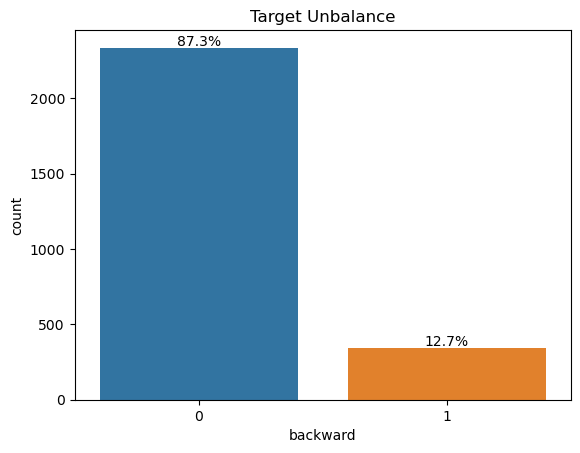

In [7]:
ax = sns.countplot( x = X.backward )
ax.set( title = 'Target Unbalance' )

percentage = [ X.backward.value_counts()[0] / sum( X.backward.value_counts() ) * 100.0,
               X.backward.value_counts()[1] / sum( X.backward.value_counts() ) * 100.0 ]

patches = ax.patches
for i in range( len( patches ) ):
    pos_x = patches[i].get_x() + patches[i].get_width()/2
    pos_y = patches[i].get_height() + 15.0
    ax.annotate( text = '{:.1f}%'.format( percentage[i] ),
                 xy = (pos_x, pos_y),
                 ha = 'center' )

<font color="blue">
    <h4>CORRELATION:</h4>
    <li>Backward has very low correlation with all features.</li>
    <li>Only 8 features have a correlation more than 0.10.</li>
</font>

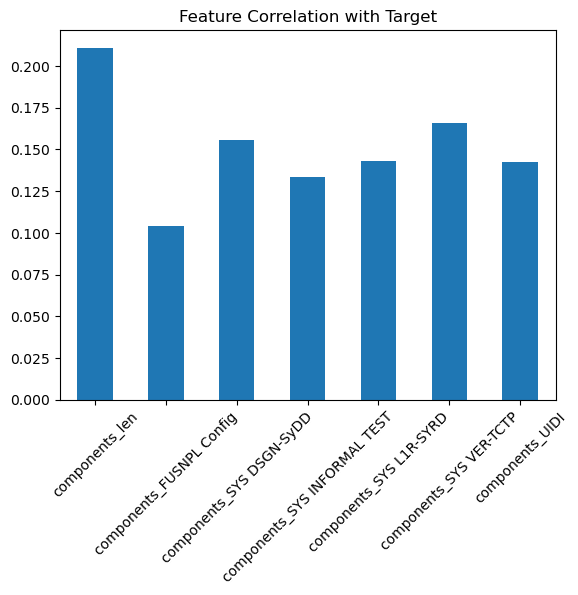

In [8]:
matrix = X.select_dtypes( include = np.number ).corr().backward
ax = matrix[ abs( matrix ) >= 0.10 ].drop( labels = 'backward' ).plot( kind = 'bar' )
ax.set( title = 'Feature Correlation with Target' )
_ = plt.xticks(rotation = 45)

<font color="blue">
    <h4>DATA TYPE: TEXT LENGTH</h4>
    <li>The distribution of text length seems similar between target 0 or 1.</li>
    <li>Summary is a one-liner text field, number of sentence feature does not make sense and should be dropped. </li>
    <li>There are outlier that should be removed.</li>
</font>

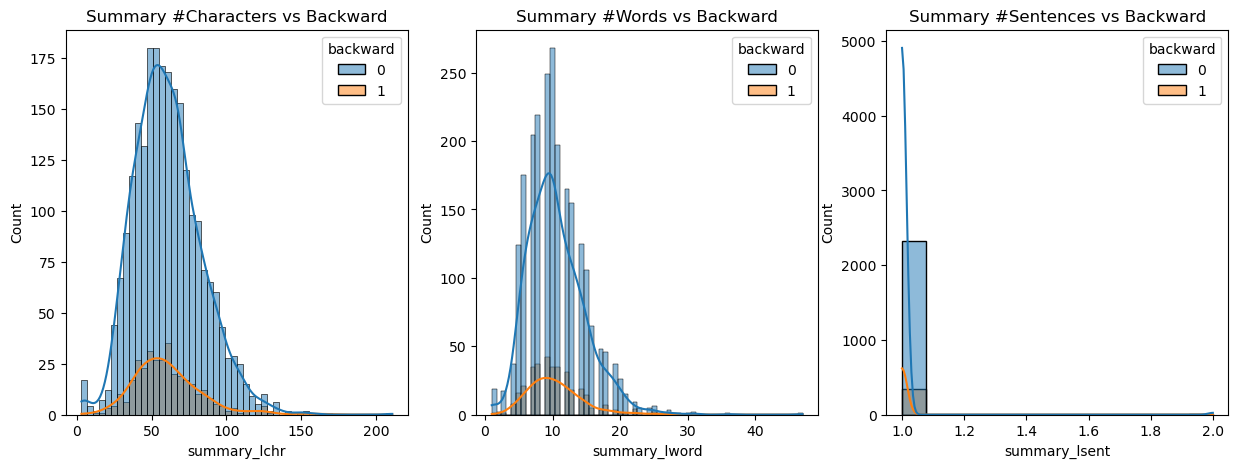

In [9]:
fig, axes = plt.subplots( 1, 3, figsize = ( 15, 5 ) )

_ = sns.histplot( data = X,
                  x = 'summary_lchr',
                  hue = 'backward',
                  kde = True,
                  ax = axes[0],
                  log_scale = False ).set( title = 'Summary #Characters vs Backward' )

_ = sns.histplot( data = X,
                  x = 'summary_lword',
                  hue = 'backward',
                  kde = True,
                  ax = axes[1],
                  log_scale = False ).set( title = 'Summary #Words vs Backward' )

_ = sns.histplot( data = X,
                  x = 'summary_lsent',
                  hue = 'backward',
                  kde = True,
                  ax = axes[2],
                  log_scale = False ).set( title = 'Summary #Sentences vs Backward' )

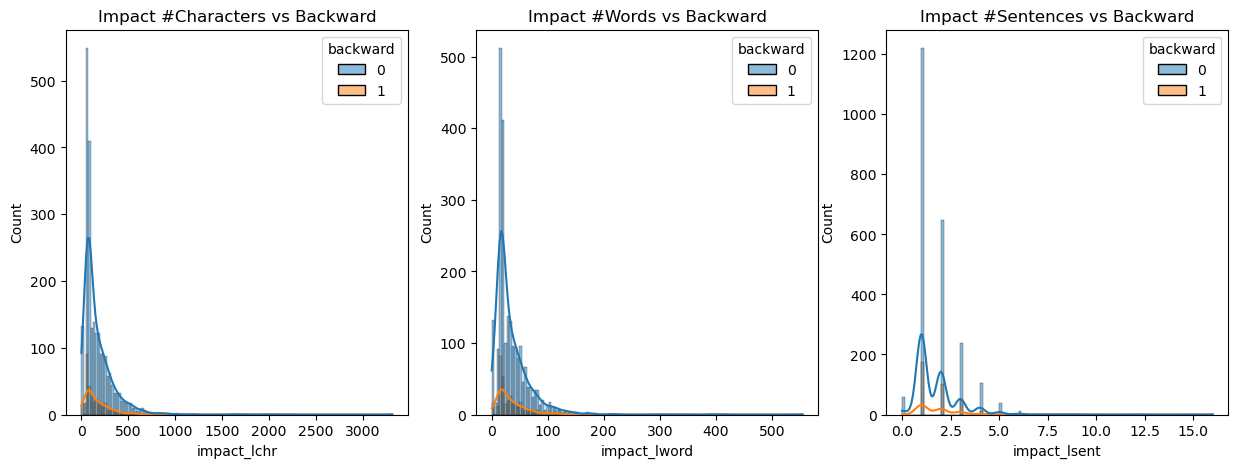

In [10]:
fig, axes = plt.subplots( 1, 3, figsize = ( 15, 5 ) )

_ = sns.histplot( data = X,
                  x = 'impact_lchr',
                  hue = 'backward',
                  kde = True,
                  ax = axes[0],
                  log_scale = False ).set( title = 'Impact #Characters vs Backward' )

_ = sns.histplot( data = X,
                  x = 'impact_lword',
                  hue = 'backward',
                  kde = True,
                  ax = axes[1],
                  log_scale = False ).set( title = 'Impact #Words vs Backward' )

_ = sns.histplot( data = X,
                  x = 'impact_lsent',
                  hue = 'backward',
                  kde = True,
                  ax = axes[2],
                  log_scale = False ).set( title = 'Impact #Sentences vs Backward' )

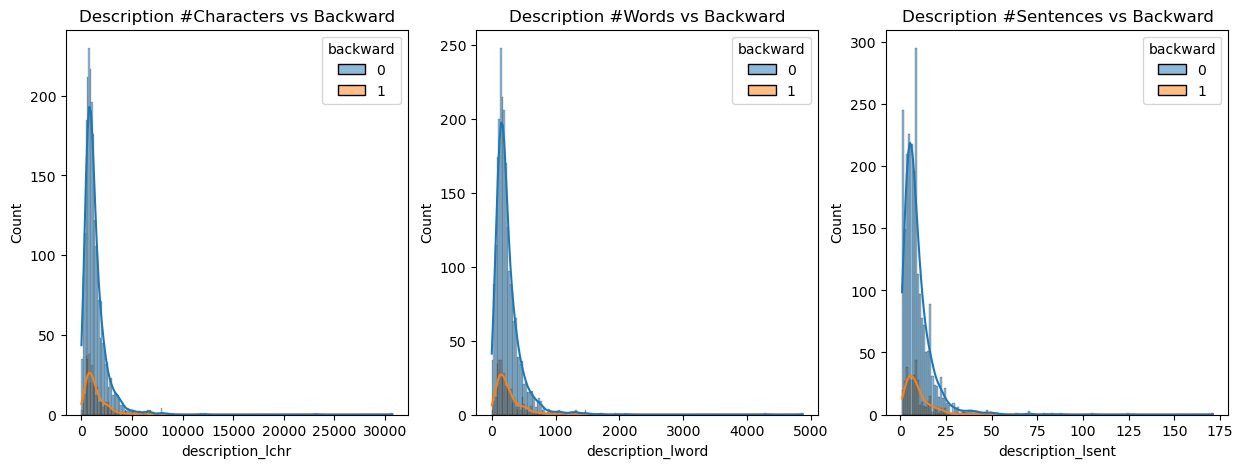

In [11]:
fig, axes = plt.subplots( 1, 3, figsize = ( 15, 5 ) )

_ = sns.histplot( data = X,
                  x = 'description_lchr',
                  hue = 'backward',
                  kde = True,
                  ax = axes[0],
                  log_scale = False ).set( title = 'Description #Characters vs Backward' )

_ = sns.histplot( data = X,
                  x = 'description_lword',
                  hue = 'backward',
                  kde = True,
                  ax = axes[1],
                  log_scale = False ).set( title = 'Description #Words vs Backward' )

_ = sns.histplot( data = X,
                  x = 'description_lsent',
                  hue = 'backward',
                  kde = True,
                  ax = axes[2],
                  log_scale = False ).set( title = 'Description #Sentences vs Backward' )

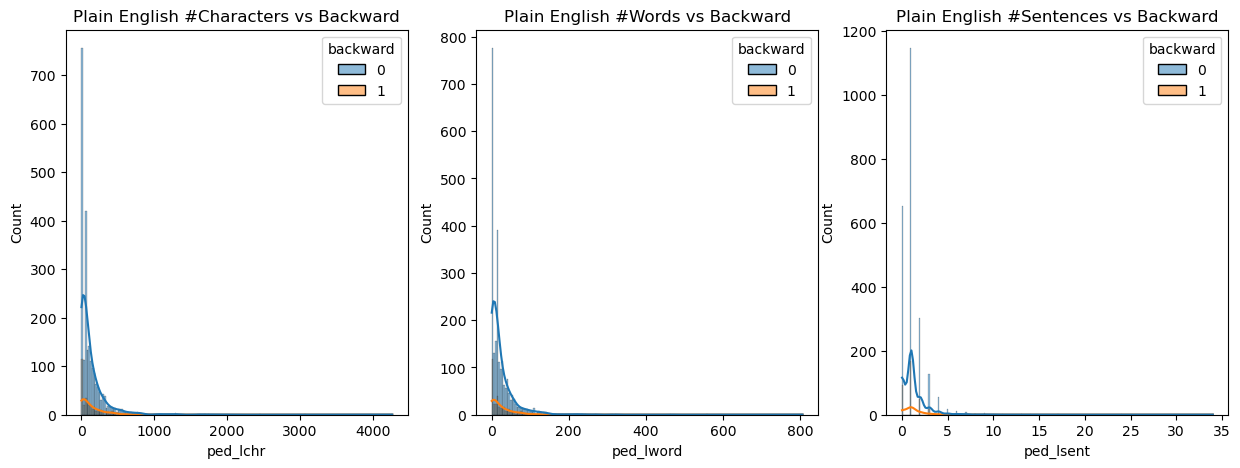

In [12]:
fig, axes = plt.subplots( 1, 3, figsize = ( 15, 5 ) )

_ = sns.histplot( data = X,
                  x = 'ped_lchr',
                  hue = 'backward',
                  kde = True,
                  ax = axes[0],
                  log_scale = False ).set( title = 'Plain English #Characters vs Backward' )

_ = sns.histplot( data = X,
                  x = 'ped_lword',
                  hue = 'backward',
                  kde = True,
                  ax = axes[1],
                  log_scale = False ).set( title = 'Plain English #Words vs Backward' )

_ = sns.histplot( data = X,
                  x = 'ped_lsent',
                  hue = 'backward',
                  kde = True,
                  ax = axes[2],
                  log_scale = False ).set( title = 'Plain English #Sentences vs Backward' )

<font color="blue">
    <h4>DATA TYPE: LISTS</h4>
    <li>As the number of components increases, the more likely the issues is going backward.</li>
    <li>There are outliers to remove.</li>
</font>

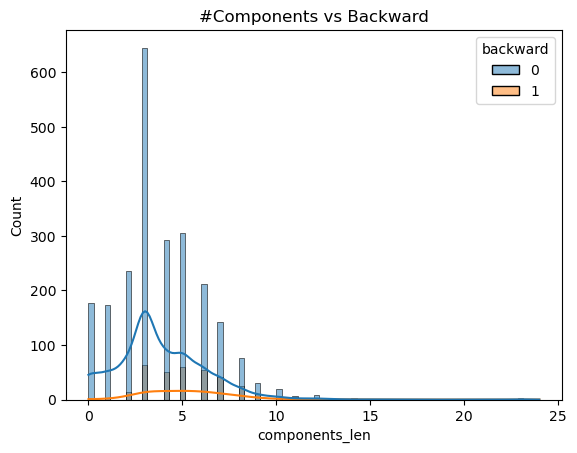

In [13]:
_ = sns.histplot( data = X,
                  x = 'components_len',
                  hue = 'backward',
                  kde = True,
                  log_scale = False ).set( title = '#Components vs Backward' )

<font color="blue">
    <h4>DATA TYPE: CATEGORIES</h4>
    <li>'Enhancement' and 'Program Planned' are more likely to go backward.</li>
</font>

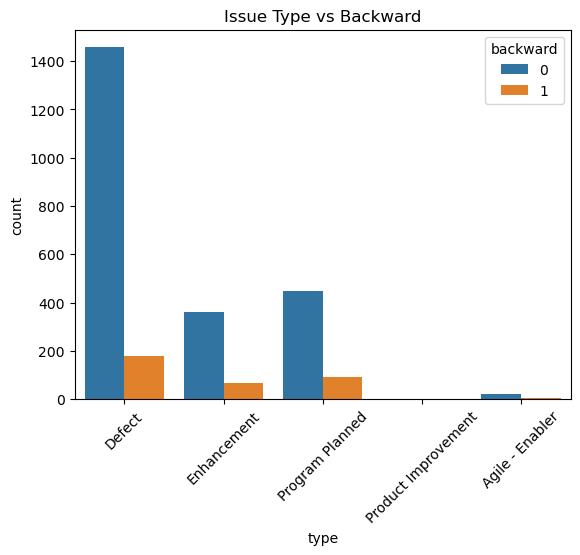

In [14]:
ax = sns.countplot( data = X,
                    x = 'type',
                    hue = 'backward' )
ax.set( title = 'Issue Type vs Backward' )
_ = plt.xticks( rotation = 45 )

<font color="blue">
    <h4>DATA TYPE: WORDS</h4>
    <li>Looking a the top 20 ranked words, we can see a few words that are more frequent within issues that go backward: control, need, ca, new, feature, mode, entry, see, field.</li>
    <li>Some of these words are related to previously observations. New features are more likely to go backward.</li>
    <li>By comparing the words frequency ranking, we can see which words have a strong likelyhood to belong to each category. For example, the words 'src', 'performance' and 'tag' are more likely to show up in issues going backwards. While words 'pba', 'inbd', 'hfom' are more common in issues NOT going backwards.</li>
    <li>Lastly, there are words that show up only in issues that went backwards and other words that only show up in issues NOT going backward.</li>
</font>

In [15]:
%%time

template_words = [ 'ccb',
                   'deck',
                   'effect',
                   'expected',
                   'flight',
                   'fusnpl',
                   'issue',
                   'observed',
                   'operation',
                   'recommendation',
                   'scenario',
                   'workaround' ]

def wordFreq( data_frame ):
    tokens = []
    for c in col_text:
        sentence = ' '.join( data_frame[ c ].fillna( '' ) )
        new_tokens = nltk.word_tokenize( sentence, language = 'english' )
        new_tokens = [ t.lower() for t in new_tokens ]
        new_tokens = [ t for t in new_tokens if t not in nltk.corpus.stopwords.words( 'english' ) ]
        new_tokens = [ t for t in new_tokens if t not in template_words ]
        new_tokens = [ t for t in new_tokens if t.isalpha() ]
        lemmatizer = nltk.stem.WordNetLemmatizer()
        new_tokens = [ lemmatizer.lemmatize( t ) for t in new_tokens ]
        tokens = tokens + new_tokens
    counts = collections.Counter( tokens )
    return pd.DataFrame( counts.items(),
                         columns = [ 'word', 'frequency' ] ).sort_values( by = 'frequency',
                                                                          ascending = False )

freq_back0 = wordFreq( X[ X.backward == 0 ] )
freq_back1 = wordFreq( X[ X.backward == 1 ] )

CPU times: total: 4min 18s
Wall time: 4min 18s


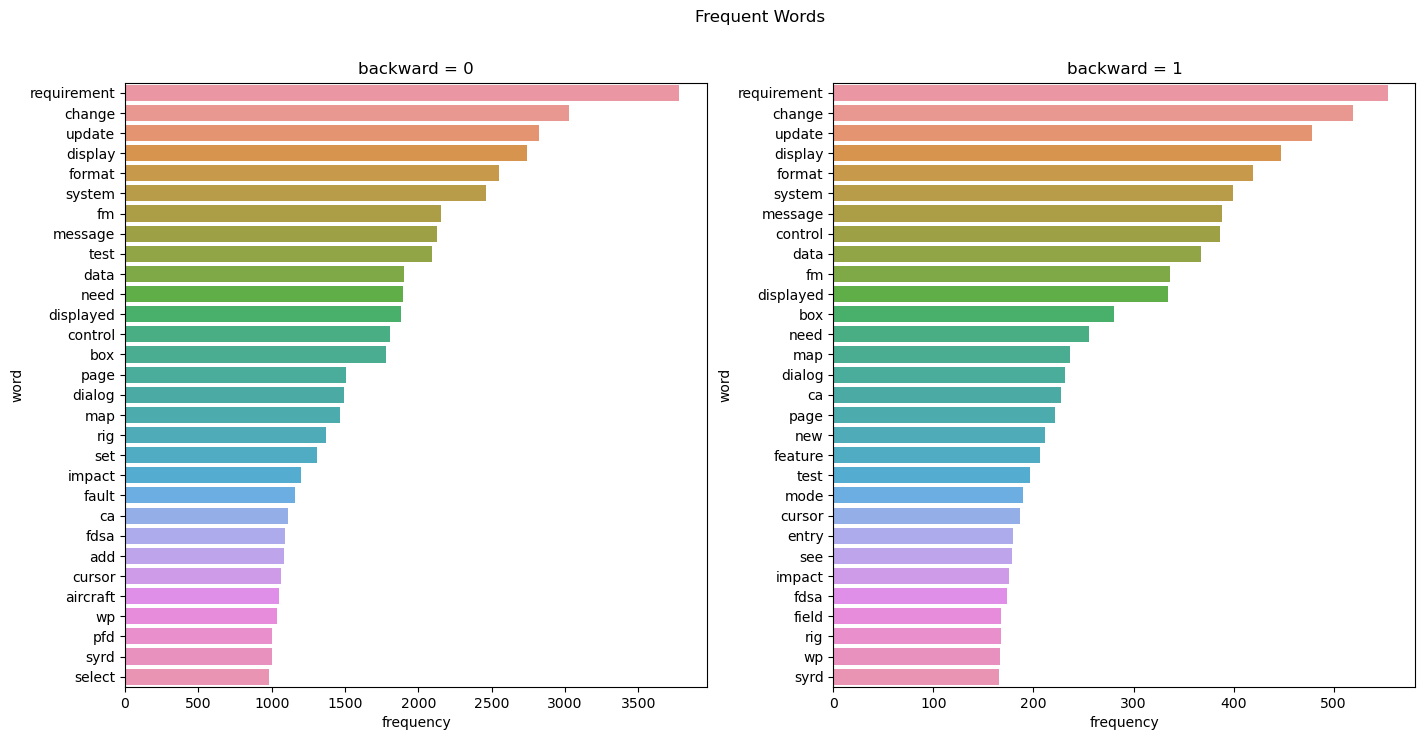

In [16]:
fig, axes = plt.subplots( 1, 2, figsize = ( 15, 8 ) )

fig.tight_layout( pad = 6.0 )

fig.suptitle( 'Frequent Words' )

axes[ 0 ].title.set_text( 'backward = 0' )
_ = sns.barplot( ax = axes[ 0 ],
                 x = 'frequency',
                 y = 'word',
                 data = freq_back0.head( 30 ) )

axes[ 1 ].title.set_text( 'backward = 1' )
_ = sns.barplot( ax = axes[ 1 ],
                 x = 'frequency',
                 y = 'word',
                 data = freq_back1.head( 30 ) )

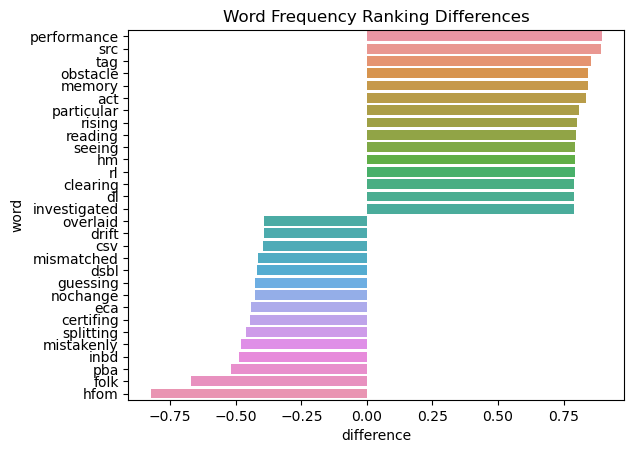

In [17]:
df0 = freq_back0.reset_index().drop( columns = [ 'index' ] )
df0 = df0.rename( columns = { 'frequency': 'frequency0' } )
df0['rank0'] = df0.index / len( df0 )

df1 = freq_back1.reset_index().drop( columns = [ 'index' ] )
df1 = df1.rename( columns = { 'frequency': 'frequency1' } )
df1['rank1'] = df1.index / len( df1 )

df2 = pd.merge( left = df0,
                right = df1,
                left_on = 'word',
                right_on = 'word',
                how = 'outer' )
df2[ 'difference' ] = df2.rank1 - df2.rank0
df2 = df2.sort_values( 'difference', ascending = False )
_ = sns.barplot( data = pd.concat( objs = [ df2.dropna().head(15)[['word','difference']],
                                            df2.dropna().tail(15)[['word','difference']] ] ),
                 y = 'word',
                 x = 'difference' ).set( title = 'Word Frequency Ranking Differences' )

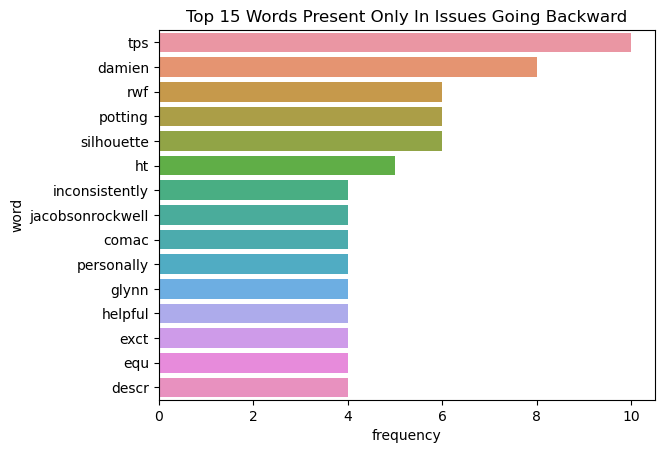

In [18]:
_ = sns.barplot( data = df2[ df2.rank0.isna() ][ [ 'word', 'frequency1' ] ].head( 15 ),
                 y = 'word',
                 x = 'frequency1' ).set( title = 'Top 15 Words Present Only In Issues Going Backward' )
_ = plt.xlabel( 'frequency' )

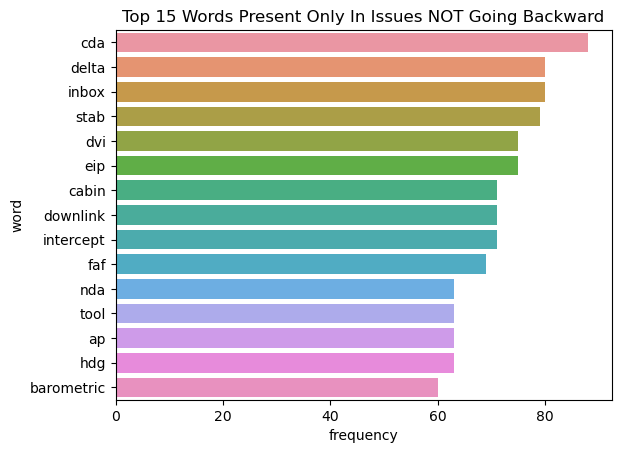

In [19]:
_ = sns.barplot( data = df2[ df2.rank1.isna() ][ [ 'word', 'frequency0' ] ].head( 15 ),
                 y = 'word',
                 x = 'frequency0' ).set( title = 'Top 15 Words Present Only In Issues NOT Going Backward' )
_ = plt.xlabel( 'frequency' )

# Post EDA Cleanup

<font color="blue">
    <h4>One Hot Encoding</h4>
</font>

In [20]:
for c in [ 'type' ]: # 'project'
    
    # INSTANTIATE THE ENCODER AND TRANSFORM THE COLUMN
    encoder = preprocessing.OneHotEncoder()
    matrix = encoder.fit_transform( X[ [ c ] ] )
    
    # REPLACE THE ORIGINAL COLUMN WITH THE ENCODER RESULT
    matrix_df = pd.DataFrame( data = matrix.toarray(),
                              columns = encoder.get_feature_names_out() )
    X = pd.concat( objs = [ X.drop( columns = c ), matrix_df ],
                   axis = 1 )

<font color="blue">
    <h4>Remove Features</li>
</font>

In [21]:
X = X.drop( columns = [ 'summary_lsent' ] )

<font color="blue">
    <h4>Remove Outliers</li>
</font>

In [22]:
outliers = [ 'summary_lchr', 'summary_lword',
             'impact_lchr', 'impact_lword',
             'description_lchr', 'description_lword', 'description_lsent',
             'ped_lchr', 'ped_lword'
           ]

for c in outliers:
    
    q1 = X[ c ].quantile( 0.25 )
    q3 = X[ c ].quantile( 0.75 )
    iqr = q3 - q1
    upper_inner_fence = q3 + (1.5 * iqr)
    X = X[ ( X[ c ] > 0 ) & ( X[ c ] < upper_inner_fence ) ]

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 2674
Columns: 116 entries, criticality to type_None
dtypes: float64(7), int32(92), int64(13), object(4)
memory usage: 741.6+ KB


# Training / Validation / Testing Split

In [24]:
y = X.backward
X = X.drop( columns = [ 'backward' ] )

X_train, X_val, y_train, y_val = model_selection.train_test_split( X, y,
                                                                   test_size = 0.8,
                                                                   shuffle = True,
                                                                   stratify = y )

X_val, X_test, y_val, y_test = model_selection.train_test_split( X_val, y_val,
                                                                 test_size = 0.5,
                                                                 shuffle = True,
                                                                 stratify = y_val )

datasets = [ X_train, X_val, X_test ]

print( '# Samples:' )
print( '  Training:', len( X_train ) )
print( '  Validation:', len( X_val ) )
print( '  Testing:', len( X_test ) )

# Samples:
  Training: 267
  Validation: 535
  Testing: 535


# Data Transformation
- Fit on train, apply to train, val, test to avoid data contamination

<font color="blue">
    <h4>Count Vectors</h4>
</font>

In [25]:
# INSTANTIATE VECTORIZERS
vectorizers = {}
for c in col_text:
    vectorizer = feature_extraction.text.CountVectorizer( analyzer = 'word',
                                                          token_pattern = r'\w{1,}' )
    vectorizer.fit( X_train[ c ] )
    vectorizers[ c ] = vectorizer

# APPLY VECTORIZER TO EACH SET
counts = []
for ds in datasets:
    
    df = None
    
    for c in col_text:
        
        # GRAB VECTORIZER FOR THE COLUMN AND USE IT
        matrix = vectorizers[ c ].transform( ds[ c ] )
        
        # CONVERT THE TRANSORMED MATRIX INTO A DATAFRAME
        matrix_df = pd.DataFrame( data = matrix.toarray(),
                                  index = ds[ c ].index,
                                  columns = c + '_' + vectorizers[ c ].get_feature_names_out() )
        
        # CONCATENATE ALL CONVERTED COLUMNS INTO A SINGLE DATAFRAME
        if df is None:
            df = matrix_df
        else:
            df = pd.concat( objs = [ df, matrix_df ],
                            axis = 1 )
        
    counts.append( df )

# SAVE TO DISK AS RESTORE POINT
counts[0].to_pickle( 'data/counts_train.pkl' )
counts[1].to_pickle( 'data/counts_val.pkl' )
counts[2].to_pickle( 'data/counts_test.pkl' )

<font color="blue">
    <h4>Word Level TF-IDF Vectors</h4>
</font>

In [26]:
# INSTANTIATE VECTORIZERS
vectorizers = {}
for c in col_text:
    vectorizer = feature_extraction.text.TfidfVectorizer( analyzer = 'word',
                                                          token_pattern = r'\w{1,}',
                                                          max_features = 5000 )
    vectorizer.fit( X_train[ c ] )
    vectorizers[ c ] = vectorizer

# APPLY VECTORIZER TO EACH SET
word_tfidf = []
for ds in datasets:
    
    df = None
    
    for c in col_text:
        
        # GRAB VECTORIZER FOR THE COLUMN AND USE IT
        matrix = vectorizers[ c ].transform( ds[ c ] )
        
        # CONVERT THE TRANSORMED MATRIX INTO A DATAFRAME
        matrix_df = pd.DataFrame( data = matrix.toarray(),
                                  index = ds[ c ].index,
                                  columns = c + '_' + vectorizers[ c ].get_feature_names_out() )
        
        # CONCATENATE ALL CONVERTED COLUMNS INTO A SINGLE DATAFRAME
        if df is None:
            df = matrix_df
        else:
            df = pd.concat( objs = [ df, matrix_df ],
                            axis = 1 )
        
    word_tfidf.append( df )

# SAVE TO DISK AS RESTORE POINT
word_tfidf[0].to_pickle( 'data/word_train.pkl' )
word_tfidf[1].to_pickle( 'data/word_val.pkl' )
word_tfidf[2].to_pickle( 'data/word_test.pkl' )

<font color="blue">
    <h4>N-gram Level TF-IDF Vectors</h4>
</font>

In [27]:
# INSTANTIATE VECTORIZERS
vectorizers = {}
for c in col_text:
    vectorizer = feature_extraction.text.TfidfVectorizer( analyzer = 'word',
                                                          token_pattern = r'\w{1,}',
                                                          ngram_range = (2,3),
                                                          max_features = 5000 )
    vectorizer.fit( X_train[ c ] )
    vectorizers[ c ] = vectorizer

# APPLY VECTORIZER TO EACH SET
ngram_tfidf = []
for ds in datasets:
    
    df = None
    
    for c in col_text:
        
        # GRAB VECTORIZER FOR THE COLUMN AND USE IT
        matrix = vectorizers[ c ].transform( ds[ c ] )
        
        # CONVERT THE TRANSORMED MATRIX INTO A DATAFRAME
        matrix_df = pd.DataFrame( data = matrix.toarray(),
                                  index = ds[ c ].index,
                                  columns = c + '_' + vectorizers[ c ].get_feature_names_out() )
        
        # CONCATENATE ALL CONVERTED COLUMNS INTO A SINGLE DATAFRAME
        if df is None:
            df = matrix_df
        else:
            df = pd.concat( objs = [ df, matrix_df ],
                            axis = 1 )
        
    ngram_tfidf.append( df )

# SAVE TO DISK AS RESTORE POINT
ngram_tfidf[0].to_pickle( 'data/ngram_train.pkl' )
ngram_tfidf[1].to_pickle( 'data/ngram_val.pkl' )
ngram_tfidf[2].to_pickle( 'data/ngram_test.pkl' )

<font color="blue">
    <h4>Character Level TF-IDF Vectors</h4>
</font>

In [28]:
# INSTANTIATE VECTORIZERS
vectorizers = {}
for c in col_text:
    vectorizer = feature_extraction.text.TfidfVectorizer( analyzer = 'char',
                                                          ngram_range = (2,3),
                                                          max_features = 5000 )
    vectorizer.fit( X_train[ c ].apply( lambda txt: re.sub( r'[^\w\s]', '', txt ) ) )  # REMOVE PUNCTUATION
    vectorizers[ c ] = vectorizer

# APPLY VECTORIZER TO EACH SET
char_tfidf = []
for ds in datasets:
    
    df = None
    
    for c in col_text:
        
        # GRAB VECTORIZER FOR THE COLUMN AND USE IT
        matrix = vectorizers[ c ].transform( ds[ c ].apply( lambda txt: re.sub( r'[^\w\s]', '', txt ) ) )
        
        # CONVERT THE TRANSORMED MATRIX INTO A DATAFRAME
        matrix_df = pd.DataFrame( data = matrix.toarray(),
                                  index = ds[ c ].index,
                                  columns = c + '_' + vectorizers[ c ].get_feature_names_out() )
        
        # CONCATENATE ALL CONVERTED COLUMNS INTO A SINGLE DATAFRAME
        if df is None:
            df = matrix_df
        else:
            df = pd.concat( objs = [ df, matrix_df ],
                            axis = 1 )
        
    char_tfidf.append( df )

# SAVE TO DISK AS RESTORE POINT
char_tfidf[0].to_pickle( 'data/char_train.pkl' )
char_tfidf[1].to_pickle( 'data/char_val.pkl' )
char_tfidf[2].to_pickle( 'data/char_test.pkl' )

<font color="blue">
    <h4>Embeddings</h4>
    <li>Each will be a 2D matrix of (sentences / embeddings)</li>
</font>

In [29]:
%%time

# READ IN EMBEDDINGS
sbert = SentenceTransformer( model_name_or_path = 'all-MiniLM-L6-v2',
                             device = 'cuda' )

n_embeddings = sbert.get_sentence_embedding_dimension()

# APPLY TO EACH SET
embeddings = []
for ds in datasets:
    
    print( 'set:' )
    
    df = None
    
    for c in col_text:

        print( '  ', c, 'to sentences...' )

        # BREAK INTO SENTENCES
        series = ds[ c ].apply( lambda txt: nltk.sent_tokenize( text = txt,
                                                                language = 'english' ) )
        
        print( '  ', c, 'to embeddings...' )
        
        # SENTENCES TO EMBEDDINGS
        series = series.apply( lambda sentences: sbert.encode( sentences = sentences,
                                                               convert_to_numpy  = True,
                                                               show_progress_bar = False ) )
        
        # PAD FOR MISSING VALUES
        series = series.apply( lambda x: np.array( [ np.zeros( shape = n_embeddings ) ] ) if len( x ) == 0 else x )
        
        if df is None:
            df = pd.DataFrame( series )
        else:
            df = pd.concat( objs = [ df, series ],
                            axis = 1 )
                
    embeddings.append( df )
    print()
    
# PAD FOR CONSTANT SIZE ACCROSS ALL SETS
max_vectors = {}
for c in col_text:
    
    print( c, 'padding...' )
    
    # INITIALIZE MAX NUMBER OF VECTORS
    max_vectors[ c ] = 0
    
    # FIND THE LARGEST NUMBER OF VECTORS ACROSS ALL SETS
    for ds in embeddings:
        max_vectors[ c ] = max( max_vectors[ c ], max( ds[ c ].apply( len ) ) )
    
    # APPLY PADDING TO REACH MAX NUMBER OF VECTORS
    for ds in embeddings:
        ds[ c ] = ds[ c ].apply( lambda vectors: np.pad( array = vectors,
                                                                  pad_width = ( (0, max_vectors[ c ] - len( vectors )), (0,0)) )
                                                      if vectors.shape != (max_vectors[ c ],n_embeddings) else vectors )

# SAVE TO DISK AS RESTORE POINT
embeddings[0].to_pickle( 'data/embedding_train.pkl' )
embeddings[1].to_pickle( 'data/embedding_val.pkl' )
embeddings[2].to_pickle( 'data/embedding_test.pkl' )

set:
   summary to sentences...
   summary to embeddings...
   impact to sentences...
   impact to embeddings...
   description to sentences...
   description to embeddings...
   ped to sentences...
   ped to embeddings...

set:
   summary to sentences...
   summary to embeddings...
   impact to sentences...
   impact to embeddings...
   description to sentences...
   description to embeddings...
   ped to sentences...
   ped to embeddings...

set:
   summary to sentences...
   summary to embeddings...
   impact to sentences...
   impact to embeddings...
   description to sentences...
   description to embeddings...
   ped to sentences...
   ped to embeddings...

summary padding...
impact padding...
description padding...
ped padding...
CPU times: total: 3min 20s
Wall time: 3min 16s


<font color="blue">
    <h4>Drop Raw Text</h4>
    <li>we will use vectors instead</li>
</font>

In [30]:
X_train = X_train.drop( columns = col_text )
X_val   = X_val.drop( columns = col_text )
X_test  = X_test.drop( columns = col_text )

# SAVE TO DISK AS RESTORE POINT
X_train.to_pickle( 'data/X_train.pkl' )
X_val.to_pickle( 'data/X_val.pkl' )
X_test.to_pickle( 'data/X_test.pkl' )

y_train.to_pickle( 'data/y_train.pkl' )
y_val.to_pickle( 'data/y_val.pkl' )
y_test.to_pickle( 'data/y_test.pkl' )

# Restore Point

In [31]:
# NUMERICAL FEATURES
X_train = pd.read_pickle( 'data/X_train.pkl' )
X_val   = pd.read_pickle( 'data/X_val.pkl' )
X_test  = pd.read_pickle( 'data/X_test.pkl' )

# TARGET
y_train = pd.read_pickle( 'data/y_train.pkl' )
y_val   = pd.read_pickle( 'data/y_val.pkl' )
y_test  = pd.read_pickle( 'data/y_test.pkl' )

In [32]:
# BAGS OF WORDS
counts = []
counts.append( pd.read_pickle( 'data/counts_train.pkl' ) )
counts.append( pd.read_pickle( 'data/counts_val.pkl' ) )
counts.append( pd.read_pickle( 'data/counts_test.pkl' ) )

In [33]:
# WORD LEVEL TD-IDF
word_tfidf = []
word_tfidf.append( pd.read_pickle( 'data/word_train.pkl' ) )
word_tfidf.append( pd.read_pickle( 'data/word_val.pkl' ) )
word_tfidf.append( pd.read_pickle( 'data/word_test.pkl' ) )

In [34]:
# N-GRAM LEVEL TD-IDF
ngram_tfidf = []
ngram_tfidf.append( pd.read_pickle( 'data/ngram_train.pkl' ) )
ngram_tfidf.append( pd.read_pickle( 'data/ngram_val.pkl' ) )
ngram_tfidf.append( pd.read_pickle( 'data/ngram_test.pkl' ) )

In [35]:
# CHARACTER LEVEL TD-IDF
char_tfidf = []
char_tfidf.append( pd.read_pickle( 'data/char_train.pkl' ) )
char_tfidf.append( pd.read_pickle( 'data/char_val.pkl' ) )
char_tfidf.append( pd.read_pickle( 'data/char_test.pkl' ) )

In [36]:
# EMBEDDINGS
embeddings = []
embeddings.append( pd.read_pickle( 'data/embedding_train.pkl' ) )
embeddings.append( pd.read_pickle( 'data/embedding_val.pkl' ) )
embeddings.append( pd.read_pickle( 'data/embedding_test.pkl' ) )

# Modeling

In [37]:
# COMMON MODEL EVALUATION METHOD
def train_model( model, kfolds, name, params, train_X, train_y, val_X, val_y, test_X, test_y, results ):

    #DEFINE CROSS VALIDATION
    Xdf = pd.concat( objs = (train_X, val_X), axis = 0 )
    ydf = pd.concat( objs = (train_y, val_y), axis = 0 )
        
    if kfolds:
        cv = model_selection.RepeatedStratifiedKFold( n_splits = 5,
                                                      n_repeats = 10 )
        results[ 'CV' ].append( 'K-folds' )
        
    else:
        # BUILD A PREDEFINED SPLIT CROSS VALIDATION
        split_index = [-1]*len(train_X) + [0]*len(val_X)
        cv = model_selection.PredefinedSplit( test_fold = split_index )
        results[ 'CV' ].append( 'Split' )
    
    # DEFINE THE GRID SEARCH
    grid = model_selection.GridSearchCV( estimator = model,
                                         param_grid = params,
                                         scoring = 'f1',
                                         cv = cv,
                                         verbose = 0,
                                         return_train_score = True )
    
    # FIT CLASSIFIER WITH THE TRAINING SET
    grid.fit( Xdf, ydf )
    
    # TRAIN / VAL SCORES
    best = pd.DataFrame( data = grid.cv_results_ )
    best = best[ best.rank_test_score == 1 ]
    
    # PREDICT THE LABELS ON VALIDATION SET
    predictions = grid.predict( test_X )
    
    # SAVE RESULTS
    results[ 'Model'      ].append( name )    
    results[ 'Params'     ].append( grid.best_params_ )
    results[ 'Training'   ].append( best.mean_train_score.values[ 0 ] )
    results[ 'Validation' ].append( best.mean_test_score.values[ 0 ] )
    results[ 'Testing'    ].append( metrics.f1_score( predictions, test_y ) )
    
    # USER FEEDBACK
    print( '.', end = '' )

In [38]:
# REPEAT TRAINING FOR A GIVEN CLASSIFER TYPE WITH DIFFERENT INPUTS
def train_type( model, name, params ):
    
    # ALL RESULTS DICTIONARY
    results = { 'Model':      [],
                'CV':         [],
                'Params':     [],
                'Training':   [],
                'Validation': [],
                'Testing' :   [] }
    
    # WITH ON BAGS OF WORDS
    train_model( model = classifier,
                 kfolds = False,
                 name = name + ' w/Bags Of Words',
                 params = params,
                 train_X = pd.concat( objs = [ X_train, counts[0] ], axis = 1 ),
                 train_y = y_train,
                 val_X = pd.concat( objs = [ X_val, counts[1] ], axis = 1 ),
                 val_y = y_val,
                 test_X = pd.concat( objs = [ X_test, counts[2] ], axis = 1 ),
                 test_y = y_test,
                 results = results )

    # WITH WORD LEVEL TF-IDF
    train_model( model = classifier,
                 kfolds = False,
                 name = name + ' w/Word TF-IDF',
                 params = params,
                 train_X = pd.concat( objs = [ X_train, word_tfidf[0] ], axis = 1 ),
                 train_y = y_train,
                 val_X = pd.concat( objs = [ X_val, word_tfidf[1] ], axis = 1 ),
                 val_y = y_val,
                 test_X = pd.concat( objs = [ X_test, word_tfidf[2] ], axis = 1 ),
                 test_y = y_test,
                 results = results )

    # WITH N-GRAM LEVEL TF-IDF
    train_model( model = classifier,
                 kfolds = False,
                 name = name + ' w/N-Gram TF-IDF',
                 params = params,
                 train_X = pd.concat( objs = [ X_train, ngram_tfidf[0] ], axis = 1 ),
                 train_y = y_train,
                 val_X = pd.concat( objs = [ X_val, ngram_tfidf[1] ], axis = 1 ),
                 val_y = y_val,
                 test_X = pd.concat( objs = [ X_test, ngram_tfidf[2] ], axis = 1 ),
                 test_y = y_test,
                 results = results )
    
    # WITH CHARACTER LEVEL TF-IDF
    train_model( model = classifier,
                 kfolds = False,
                 name = name + ' w/Char TF-IDF',
                 params = params,
                 train_X = pd.concat( objs = [ X_train, char_tfidf[0] ], axis = 1 ),
                 train_y = y_train,
                 val_X = pd.concat( objs = [ X_val, char_tfidf[1] ], axis = 1 ),
                 val_y = y_val,
                 test_X = pd.concat( objs = [ X_test, char_tfidf[2] ], axis = 1 ),
                 test_y = y_test,
                 results = results )
    
    print()
    
    return results

<font color="blue">
    <h4>Logistic Regression (Unscaled)</h4>
    <li>Poor performance, most overfitting which cannot be resolved by adjusting regularization.</li>
</font>

In [39]:
%%time

classifier = linear_model.LogisticRegression()

params = { 'penalty':      [ 'l2' ],
           'C':            [ 5.0, 2.0, 1.5, 1.0, 0.5, 0.1, 0.01, 0.001 ],
           'class_weight': [ 'balanced' ],
           'solver':       [ 'liblinear' ],
           'max_iter':     [ 10_000 ] }

results = train_type( model  = classifier,
                      name   = 'LR',
                      params = params )

pd.DataFrame( results )

....
CPU times: total: 23.2 s
Wall time: 20.2 s


,Model,CV,Params,Training,Validation,Testing
0,LR w/Bags Of Words,Split,"{'C': 0.01, 'class_weight': 'balanced', 'max_i...",0.86,0.26,0.23
1,LR w/Word TF-IDF,Split,"{'C': 5.0, 'class_weight': 'balanced', 'max_it...",1.00,0.33,0.21
2,LR w/N-Gram TF-IDF,Split,"{'C': 0.01, 'class_weight': 'balanced', 'max_i...",0.39,0.32,0.30
3,LR w/Char TF-IDF,Split,"{'C': 0.5, 'class_weight': 'balanced', 'max_it...",0.85,0.34,0.29


<font color="blue">
    <h4>Logistic Regression (Scaled)</h4>
    <li>Poor performance, all overfitting which cannot be resolved by adjusting regularization.</li>
</font>

In [40]:
%%time

classifier = pipeline.Pipeline( [ ( 'scale', preprocessing.StandardScaler() ),
                                  ( 'model', linear_model.LogisticRegression() ) ] )

params = { 'model__penalty':      [ 'l2' ],
           'model__C':            [ 1.5, 1.0, 0.5, 0.1, 0.01, 0.001 ],
           'model__class_weight': [ 'balanced' ],
           'model__solver':       [ 'liblinear' ],
           'model__max_iter':     [ 10_000 ] }

results = train_type( model  = classifier,
                      name   = 'LR',
                      params = params )

pd.DataFrame( results )

....
CPU times: total: 46 s
Wall time: 45.1 s


,Model,CV,Params,Training,Validation,Testing
0,LR w/Bags Of Words,Split,"{'model__C': 0.01, 'model__class_weight': 'bal...",0.99,0.26,0.26
1,LR w/Word TF-IDF,Split,"{'model__C': 0.1, 'model__class_weight': 'bala...",1.00,0.22,0.21
2,LR w/N-Gram TF-IDF,Split,"{'model__C': 1.5, 'model__class_weight': 'bala...",1.00,0.27,0.22
3,LR w/Char TF-IDF,Split,"{'model__C': 0.01, 'model__class_weight': 'bal...",0.99,0.23,0.23


<font color="blue">
    <h4>Naive Bayes</h4>
    <li>Poor performance, cannot be resolved by adjusting additive (Laplace/Lidstone) smoothing parameter alpha.</li>
</font>

In [41]:
%%time

classifier = naive_bayes.MultinomialNB()

params = { 'alpha': [ 1.0, 0.5, 0.1, 0.05, 0.001 ] }

results = train_type( model  = classifier,
                      name   = 'NB',
                      params = params )

pd.DataFrame( results )

....
CPU times: total: 7.31 s
Wall time: 5.94 s


,Model,CV,Params,Training,Validation,Testing
0,NB w/Bags Of Words,Split,{'alpha': 0.05},0.96,0.16,0.13
1,NB w/Word TF-IDF,Split,{'alpha': 0.05},0.93,0.18,0.20
2,NB w/N-Gram TF-IDF,Split,{'alpha': 0.05},0.93,0.16,0.25
3,NB w/Char TF-IDF,Split,{'alpha': 0.001},0.96,0.13,0.12


<font color="blue">
    <h4>Nearest Neighbhors</h4>
    <li>Poor performance, all overfitting with best performance obtain wtih 1 neighbor.</li>
</font>

In [42]:
%%time

classifier = neighbors.KNeighborsClassifier()

params = { 'n_neighbors': range( 1, 8 ) }

results = train_type( model  = classifier,
                      name   = 'KNN',
                      params = params )

pd.DataFrame( results )

....
CPU times: total: 1min 6s
Wall time: 18.7 s


,Model,CV,Params,Training,Validation,Testing
0,KNN w/Bags Of Words,Split,{'n_neighbors': 1},1.00,0.19,0.15
1,KNN w/Word TF-IDF,Split,{'n_neighbors': 1},1.00,0.18,0.15
2,KNN w/N-Gram TF-IDF,Split,{'n_neighbors': 1},1.00,0.18,0.15
3,KNN w/Char TF-IDF,Split,{'n_neighbors': 1},1.00,0.18,0.15


<font color="blue">
    <h4>Decision Tree (Pruned By Depth)</h4>
    <li>Mst not overfitting but poor performance. Pruning by depth may not be subtle enough.</li>
</font>

In [43]:
%%time

classifier = tree.DecisionTreeClassifier()

params = { 'max_depth': range( 1, 10 ),
           'class_weight' : [ None, 'balanced' ] }

results = train_type( model  = classifier,
                      name   = 'DT',
                      params = params )

pd.DataFrame( results )

....
CPU times: total: 26.4 s
Wall time: 26.4 s


,Model,CV,Params,Training,Validation,Testing
0,DT w/Bags Of Words,Split,"{'class_weight': 'balanced', 'max_depth': 8}",0.61,0.31,0.22
1,DT w/Word TF-IDF,Split,"{'class_weight': 'balanced', 'max_depth': 2}",0.36,0.27,0.29
2,DT w/N-Gram TF-IDF,Split,"{'class_weight': 'balanced', 'max_depth': 1}",0.36,0.27,0.30
3,DT w/Char TF-IDF,Split,"{'class_weight': 'balanced', 'max_depth': 1}",0.29,0.25,0.30


<font color="blue">
    <h4>Decision Tree (Pruned By Impurity Decrease)</h4>
    <li>Comparable poor performance when pruning by depth.</li>
</font>

In [44]:
%%time

classifier = tree.DecisionTreeClassifier()

params = { 'min_impurity_decrease': np.arange( 0.001, 0.020, 0.001 ),
           'class_weight' : [ None, 'balanced' ] }

results = train_type( model  = classifier,
                      name   = 'DT',
                      params = params )

pd.DataFrame( results )

....
CPU times: total: 1min 1s
Wall time: 1min 1s


,Model,CV,Params,Training,Validation,Testing
0,DT w/Bags Of Words,Split,"{'class_weight': 'balanced', 'min_impurity_dec...",0.64,0.33,0.30
1,DT w/Word TF-IDF,Split,"{'class_weight': 'balanced', 'min_impurity_dec...",0.79,0.25,0.24
2,DT w/N-Gram TF-IDF,Split,"{'class_weight': 'balanced', 'min_impurity_dec...",0.65,0.25,0.30
3,DT w/Char TF-IDF,Split,"{'class_weight': 'balanced', 'min_impurity_dec...",0.80,0.21,0.25


<font color="blue">
    <h4>SVM</h4>
    <li>Significantly overfitting. All sets preferring linear kernel which has no additional parameter to adjust.</li>
    <li>Possibily to be addressed with sklearn.svm.LinearSVC which has regularization. However, givn the amount of overfitting, high regularization would be needed which decreases the model's performance.</li>
</font>

In [45]:
%%time

classifier = svm.SVC()

params = { 'kernel': [ 'linear', 'poly', 'rbf', 'sigmoid' ] }

results = train_type( model  = classifier,
                      name   = 'SVC',
                      params = params )

pd.DataFrame( results )

....
CPU times: total: 12min 18s
Wall time: 10min 22s


,Model,CV,Params,Training,Validation,Testing
0,SVC w/Bags Of Words,Split,{'kernel': 'linear'},1.00,0.18,0.11
1,SVC w/Word TF-IDF,Split,{'kernel': 'linear'},1.00,0.23,0.16
2,SVC w/N-Gram TF-IDF,Split,{'kernel': 'linear'},1.00,0.19,0.16
3,SVC w/Char TF-IDF,Split,{'kernel': 'linear'},1.00,0.25,0.16


<font color="blue">
    <h4>Bagging: Random Forest</h4>
    <li>Similar to previous poor performance of basic decision tree.</li>
</font>

In [46]:
%%time

classifier = ensemble.RandomForestClassifier()

params = { 'n_estimators': [ 100 ],
           'min_impurity_decrease': np.arange( 0.001, 0.020, 0.001 ),
           'class_weight' : [ None, 'balanced' ] }

results = train_type( model  = classifier,
                      name   = 'RF',
                      params = params )

pd.DataFrame( results )

....
CPU times: total: 1min 5s
Wall time: 1min 5s


,Model,CV,Params,Training,Validation,Testing
0,RF w/Bags Of Words,Split,"{'class_weight': 'balanced', 'min_impurity_dec...",0.74,0.11,0.24
1,RF w/Word TF-IDF,Split,"{'class_weight': 'balanced', 'min_impurity_dec...",0.93,0.11,0.31
2,RF w/N-Gram TF-IDF,Split,"{'class_weight': 'balanced', 'min_impurity_dec...",0.88,0.10,0.28
3,RF w/Char TF-IDF,Split,"{'class_weight': 'balanced', 'min_impurity_dec...",1.00,0.06,0.13


<font color="blue">
    <h4>Boosting: Xtreme Gradient Boosting</h4>
    <li>Also poor results as in previous decision trees.</li>
    <li>Unable to resolve overfitting through regularization parameters.</li>
</font>

In [47]:
%%time

classifier = XGBClassifier()

params = { 'booster': [ 'gbtree' ],
           'objective': [ 'binary:logistic' ],
           'tree_method': [ 'auto' ],
           'min_split_loss': np.arange( 0.001, 0.020, 0.001 ),
           #'alpha': [ 0.25, 0.5, 1.0 ],
           #'lambda': [ 0.5, 1.0, 1.5 ],
           'scale_pos_weight': [ y_train.value_counts()[0] / y_train.value_counts()[1] ] }

results = train_type( model  = classifier,
                      name   = 'XGB',
                      params = params )

pd.DataFrame( results )

....
CPU times: total: 1h 56min 50s
Wall time: 7min 8s


,Model,CV,Params,Training,Validation,Testing
0,XGB w/Bags Of Words,Split,"{'booster': 'gbtree', 'min_split_loss': 0.011,...",1.00,0.15,0.13
1,XGB w/Word TF-IDF,Split,"{'booster': 'gbtree', 'min_split_loss': 0.012,...",1.00,0.16,0.09
2,XGB w/N-Gram TF-IDF,Split,"{'booster': 'gbtree', 'min_split_loss': 0.016,...",1.00,0.11,0.13
3,XGB w/Char TF-IDF,Split,"{'booster': 'gbtree', 'min_split_loss': 0.006,...",1.00,0.08,0.10


<font color="blue">
    <h4>Neural Networks</h4>
    <li>See separate notebook: capstoneNN.ipynb</li>
</font>